# Notebook 1 - Fuel property modeling

By Vincent Blay, November 2021

In this notebook we demonstrate the use of MACAW embeddings to describe molecules and train regression models of different molecular properties. The results illustrate the usefulness and speed of the approach and its compatibility with small and medium-sized datasets that are commonly found in the biosciences.

In [1]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn_rvm import EMRVR

import macaw
print(macaw.__version__)

from macaw import *
%run "./plotting.py"

0.1.12


## Research Octane Number (RON)

Let us load the data and look at the distribution:

In [104]:
df = pd.read_csv("../data/data_RON.csv")
smiles = df.Smiles
Y = df.RON
print(len(smiles))

194


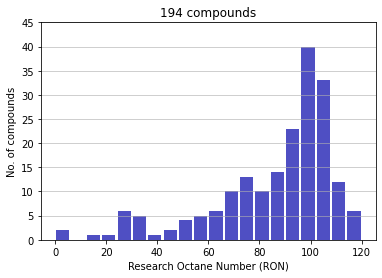

In [105]:
plot_histogram(Y, xlabel="Research Octane Number (RON)")

Let us split the data in training and validation sets:

In [106]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

Compute the MACAW embeddings of the molecules is very easy. We just initialize the embedder:

In [107]:
mcw = MACAW(random_state=42)
mcw.fit(smi_train)

And then we project the training molecules:

In [108]:
X_train = mcw.transform(smi_train)
X_train[0:4]

array([[ 0.19884805,  0.2409601 , -0.06775784, -0.02118356,  0.01205462,
         0.0092095 , -0.01561448, -0.0151575 ,  0.04589545, -0.02675224,
         0.01445283,  0.0022183 ,  0.02020615, -0.00287598,  0.0334231 ],
       [-0.03861072, -0.07373147,  0.12948979,  0.16329053,  0.11389935,
         0.12492843,  0.17406906, -0.02258431,  0.11506867,  0.00436288,
         0.00761693, -0.07656237, -0.04965525, -0.0764287 , -0.00775711],
       [ 0.1488714 ,  0.07679446,  0.02132863, -0.02997206,  0.00108838,
        -0.01158404,  0.04001913, -0.03045062, -0.03971427,  0.01451947,
         0.00394997,  0.05331182, -0.01309209,  0.00505506,  0.02383794],
       [ 0.02841089, -0.18733468, -0.1250562 , -0.10074994,  0.03711881,
        -0.08807791, -0.16081502, -0.13302582, -0.09786195,  0.05021411,
         0.01384474,  0.03374984, -0.09693374,  0.0429507 ,  0.05853095]])

The fit and transform process can be done faster in one step using the `fit_transform` method.

A variety of fingerprints (`type_fp`) and similarity metrics (`metric`) are available and can be tuned to maximize the performance of the embedding for a given problem. The dimensionality of the embedding can be set using the `n_components` argument.

As an optional parameter, the property values can also be provided when fitting the embedder (`Y=y_train`). In this case, it will choose the landmark molecules more uniformly throughout the RON range. If not provided, landmark molecules are chosen randomly.

In [135]:
mcw = MACAW(type_fp='atompairs', metric='rogot-goldberg', n_components =15, n_landmarks=100, random_state=57)
X_train = mcw.fit_transform(smiles, Y=y_train)
X_train[0:4]

array([[-0.40130185,  0.08210583,  0.19027524, -0.164668  ,  0.0217731 ,
        -0.29688321,  0.03985101, -0.14683456,  0.11241473,  0.01223104,
         0.045353  ,  0.08147502, -0.05778315,  0.01017389, -0.04357766],
       [ 0.03606253, -0.13709874,  0.15647348,  0.05091909, -0.04166269,
         0.01842223,  0.1741296 ,  0.08845769, -0.07214221, -0.17079708,
         0.04743385,  0.0664307 ,  0.03586416,  0.00852211,  0.13308152],
       [ 0.04549525, -0.28584305, -0.08308062, -0.18802785,  0.30988297,
         0.18900348,  0.00656332, -0.02394803,  0.10900851, -0.13882069,
        -0.0670823 ,  0.16844191, -0.01884168,  0.2783186 , -0.18573517],
       [ 0.14818929, -0.18528988,  0.10278648, -0.25072034,  0.29944551,
         0.2546804 , -0.13569402, -0.11437833,  0.08961876, -0.00056613,
         0.16144403,  0.20385203, -0.11389405, -0.04488207, -0.06987032]])

In order to automate the selection of the `type_fp` and `metric`, we have implemented the function `MACAW_optimus`, which can help select a good combination. Internally, it explores a variety of embeddings by combining these hyperparameters and use them to train SVM models, which are assessed using cross_validation. The embedding leading to the best performing model is returned to the user.

In [136]:
mcw = MACAW_optimus(smi_train, y_train, verbose=True, n_components=15, n_landmarks=100, random_state=57)

Problem type identified as regression
morgan2 + tanimoto: 0.508
morgan3 + tanimoto: 0.508
rdk5 + tanimoto: 0.596
rdk7 + tanimoto: 0.613
featmorgan2 + tanimoto: 0.559
featmorgan3 + tanimoto: 0.523
maccs + tanimoto: 0.628
avalon + tanimoto: 0.446
atompairs + tanimoto: 0.656
torsion + tanimoto: 0.541
pattern + tanimoto: 0.445
secfp6 + tanimoto: 0.490
layered + tanimoto: 0.636
maccs + cosine: 0.594
maccs + dice: 0.603
maccs + sokal: 0.610
maccs + kulczynski: 0.583
maccs + mcconnaughey: 0.583
maccs + braun-blanquet: 0.579
maccs + rogot-goldberg: 0.610
maccs + asymmetric: 0.561
maccs + manhattan: 0.627
atompairs + cosine: 0.680
atompairs + dice: 0.687
atompairs + sokal: 0.654
atompairs + kulczynski: 0.675
atompairs + mcconnaughey: 0.675
atompairs + braun-blanquet: 0.651
atompairs + rogot-goldberg: 0.688
atompairs + asymmetric: 0.660
atompairs + manhattan: 0.654
layered + cosine: 0.641
layered + dice: 0.628
layered + sokal: 0.616
layered + kulczynski: 0.640
layered + mcconnaughey: 0.640
layer

The embeddings for any new molecules can be commputed easily: we just provide the SMILES to the `transform()` method of the embedder. 

Let us compute the embeddings of the test set molecules.

In [137]:
X_train = mcw.transform(smi_train)
X_test = mcw.transform(smi_test)

In [138]:
X_test.shape

(39, 15)

Now we can use the embeddings as predictors for any machine learning tool, from linear models to neural networks. In this notebook, we will mainly use Support Vector Machines (SVM) from the scikit-learn library.

As an example, here we explore a Support Vector Regressor (SVR) from the `sklearn` package.

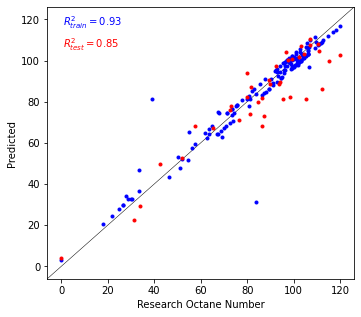

In [139]:
regr = SVR(kernel='rbf', C=100, epsilon=3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Research Octane Number", savetitle="../results/RON.png") 

As another example, we also train a relevance vector regressor (RVR) using the same MACAW features. This type of model can deal automatically with the regularization (`gamma='scale'`) and provide uncertainty estimates of the predictions. Information about this package can be found [here](https://sklearn-rvm.readthedocs.io/en/latest/index.html).

In [172]:
regr = EMRVR(kernel='rbf', gamma=8)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred, y_train_std = regr.predict(X_train, return_std=True)

# Test set predictions
y_test_pred, y_test_std = regr.predict(X_test, return_std=True)

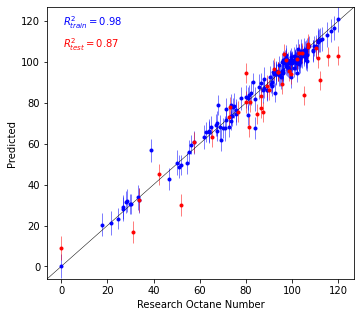

In [173]:
# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            y_train_std=y_train_std, y_test_std=y_test_std, xlabel="Research Octane Number") 

Let us save the MACAW embedder and the RON model for later use in Jupyter Notebook 3.

In [174]:
data = (mcw, regr)

picklefile = open("../results/RON_model_RVR.pickle", 'wb')
pickle.dump(data, picklefile, protocol=pickle.HIGHEST_PROTOCOL)
picklefile.close()

## Cetane Number (CN)

Here we demonstrate how MACAW embeddings can help model cetane numbers. We will use a similar approach as above. First we load the data:

In [79]:
df = pd.read_csv("../data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


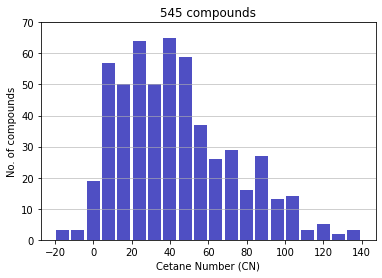

In [80]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

In [81]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

We compute the MACAW embeddings:

In [87]:
mcw = MACAW_optimus(smi_train, y_train, verbose=True, n_components=15, n_landmarks=100, random_state=77)

Problem type identified as regression
morgan2 + tanimoto: 0.637
morgan3 + tanimoto: 0.705
rdk5 + tanimoto: 0.420
rdk7 + tanimoto: 0.514
featmorgan2 + tanimoto: 0.459
featmorgan3 + tanimoto: 0.627
maccs + tanimoto: 0.513
avalon + tanimoto: 0.460
atompairs + tanimoto: 0.737
torsion + tanimoto: 0.649
pattern + tanimoto: 0.640
secfp6 + tanimoto: 0.609
layered + tanimoto: 0.563
torsion + cosine: 0.663
torsion + dice: 0.667
torsion + kulczynski: 0.655
torsion + mcconnaughey: 0.655
torsion + braun-blanquet: 0.658
torsion + rogot-goldberg: 0.668
torsion + asymmetric: 0.631
torsion + manhattan: 0.630
atompairs + cosine: 0.735
atompairs + dice: 0.743
atompairs + sokal: 0.734
atompairs + kulczynski: 0.719
atompairs + mcconnaughey: 0.719
atompairs + braun-blanquet: 0.728
atompairs + rogot-goldberg: 0.745
atompairs + asymmetric: 0.692
atompairs + manhattan: 0.679
morgan3 + cosine: 0.696
morgan3 + dice: 0.687
morgan3 + sokal: 0.680
morgan3 + kulczynski: 0.697
morgan3 + mcconnaughey: 0.697
morgan3 + 

Let us train a SVR model. We explore a few different values of the regularization constant `C` to improve its performance:

In [88]:
X_train = mcw.transform(smi_train)

for C in [30,50,100,300]:
    regr = SVR(kernel='rbf', C=C, epsilon=5)
    scores = cross_val_score(regr, X_train, y_train, cv=5)
    print(scores.mean())

0.7900453255361188
0.7999114065093791
0.8110868622004762
0.8115276345244717


We train the final model with the best value `C=100` and validate the model performance on the test set:

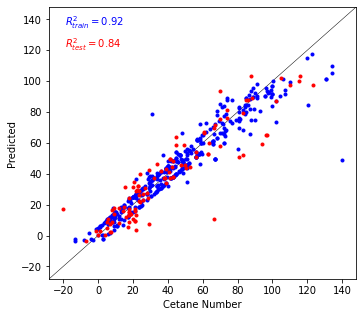

In [89]:
regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, xlabel="Cetane Number", 
            y_test=y_test_pred, savetitle="../results/CN.png") 

## Yield Sooting Index

Here we demonstrate how MACAW embeddings can help model Yield Soot Index (YSI), another complex molecular property.

In [90]:
df = pd.read_csv('../data/data_YSI.csv')
smiles = df.Smiles
Y = df.YSI
print(len(smiles))

610


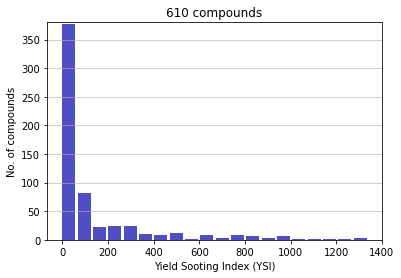

In [91]:
plot_histogram(Y, xlabel="Yield Sooting Index (YSI)")

In this case, we see that the data distribution is very skewed. There are different approaches to deal with this, for example, we could transform the YSI values to  get a more uniform distribution. For illustration purposes, we will work with the data as is.

We apply a stratified sampling to hold out the validation set in this case:

In [92]:
bins = np.linspace(min(Y), max(Y), 10+1)
Y_binned = np.digitize(Y, bins[:-1])
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42, stratify=Y_binned)

Next we compute the MACAW embeddings using only training data. In a case like this, it is recommended to provide property information (`Y=y_train`) to achieve a more balanced choice of landmarks. 

In [93]:
mcw = MACAW_optimus(smi_train, y_train, random_state=29)

X_train = mcw.transform(smi_train)

Problem type identified as regression
Setting recommended combination: atompairs + braun-blanquet


Since we did not transform the YSI data, we may want to introduce sample weights in the model. The way we do it here is by binning molecules as a function of YSI values, and then 
setting the weight of each datum in inverse proportion to the number of molecules in the bucket.

In [94]:
nbins = 10
leny = len(y_train)
bins = np.linspace(min(y_train), max(y_train), nbins+1)
y_binned = np.digitize(y_train, bins[:-1])
weights = [1./nbins]*leny
for i in range(leny):
    weights[i] = weights[i]/sum(y_binned==y_binned[i])
weights = np.asarray(weights)
weights = weights/weights.mean()

Now we can train the model. As in the other regression examples, we use a SVR. For this model, the weights provided will scale the regularization in different regions of space, in relation to the global regularization set by `C`.

In [95]:
for C in [30,100,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=20)
 
    scores = cross_val_score(regr, X_train, y_train, cv=5, fit_params={'sample_weight': weights})
    print(scores.mean())

0.5797932929607258
0.7672552970739159
0.8061503664435989
0.8142129234246486


And we train the final model:

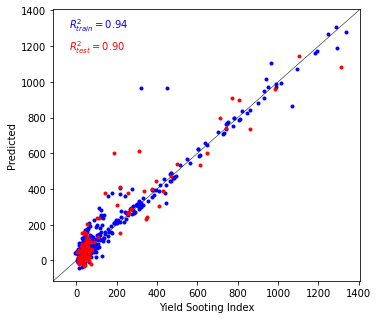

In [96]:
regr = SVR(kernel = 'rbf', C=500, epsilon=20)
regr.fit(X_train,y_train, sample_weight=weights)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, xlabel="Yield Sooting Index") 

##  Melting Point (MP)

In [9]:
df = pd.read_csv("../data/data_MP.csv")
smiles = df.Smiles
Y = df.mpC
print(len(smiles))

27976


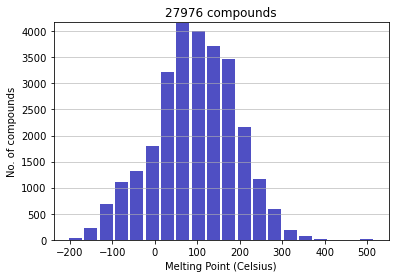

In [10]:
plot_histogram(Y, xlabel="Melting Point (Celsius)")

In [32]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

22380


In [33]:
mcw = MACAW_optimus(smi_train, y_train, C=50)

Problem type identified as regression
Setting recommended combination: maccs + dice


In [34]:
X_train = mcw.transform(smi_train)

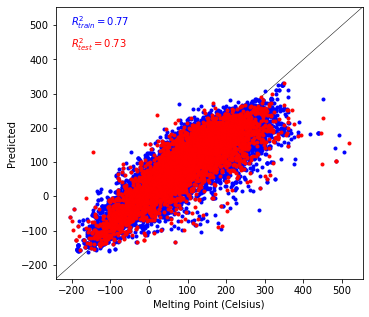

In [35]:
regr = SVR(kernel = 'rbf', C=100, epsilon = 20)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Melting Point (Celsius)", savetitle="../results/MP.png") 

MACAW also allows concatenating fingerprints, which may improve performance in some cases:

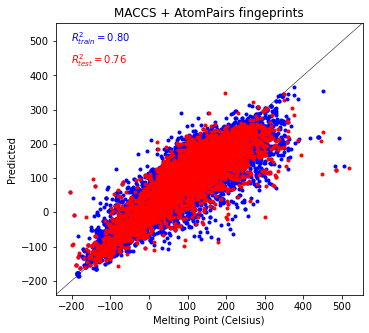

In [37]:
mcw.set_type_fp('maccs+atompairs')
mcw.set_metric('cosine')

X_train = mcw.transform(smi_train)

regr = SVR(kernel='rbf', C=100, epsilon=5)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Melting Point (Celsius)", title="MACCS + AtomPairs fingeprints") 

## Flash Point (FP)

In [97]:
df = pd.read_csv("../data/data_FP.csv")
smiles = df.Smiles
Y = df.FP
print(len(smiles))

631


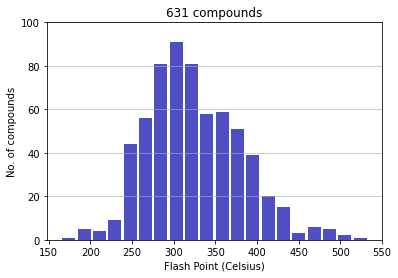

In [98]:
plot_histogram(Y, xlabel="Flash Point (Celsius)")

In [99]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)
print(len(smi_train))

504


In [101]:
mcw = MACAW_optimus(smi_train, y_train, C=300, random_state=521)

X_train = mcw.transform(smi_train)

Problem type identified as regression
Setting recommended combination: pattern + cosine


In [102]:
for C in [50,100,200,300,500]:
    regr = SVR(kernel='rbf', C=C, epsilon=2)

    scores = cross_val_score(regr, X_train, y_train, cv=5)
    print(scores.mean())

0.8249006391186118
0.8387197205453297
0.8394258852018119
0.8345391483730692
0.8303518773605418


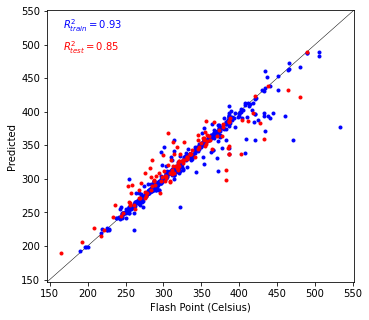

In [103]:
regr = SVR(kernel='rbf', C=300, epsilon=2)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
X_test = mcw.transform(smi_test)
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred,
            xlabel="Flash Point (Celsius)", savetitle="../results/FP.png") 